## PSO compression search on LeNet-5 

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.weight_sharing import *
from utils.pso import PSOController
from utils.plot import *

Setting some global parameters

In [2]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH = './models/lenet/saves/lenet.save'

ACC_MULTIPLIER = 4
CR_MULTIPLIER = 1

NUM_ITERATIONS = 20
NUM_PARTICLES = 20

SAVE_PSO_FILE = './results/test_PSO_save.csv'
SAVE_EVERY = 1

RANGE_OPTIMIZATION = True

Geting somewhat trained LeNet-5

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

In [4]:
lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)

ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Defining fitness function

In [5]:
particle_representation_ranges = [range(1, 21) for _ in range(5)]
particle_max_velocity = [2.5 for _ in range(5)]

share_order = [0, 1, 2, 3, 4]
retrain_amount = [0, 0, 0, 0, 0]
prec_reduct = ['f4', 'f4', 'f4', 'f4', 'f4']

def fitness_fc(particle):
    # reset the net
    get_trained(model, NET_PATH, train_settings)
    ws_controller.reset()
    
    # share weigts by particle

    particle.data = ws_controller.share(particle.representation, share_order, retrain_amount, prec_reduct)

    if particle.data['accuracy'] <= 0.95:
        #return ACC_MULTIPLIER * math.log(1/(1 - particle.data['accuracy']))
        return particle.data['accuracy']

    #return ACC_MULTIPLIER * particle.data['accuracy'] + CR_MULTIPLIER * math.log(particle.data['compression'])
    #return math.log(1/(1 - particle.data['accuracy'])) * math.log(particle.data['compression'])
    return 1 / math.sqrt(pow(1 - ((particle.data['accuracy'] - 0.9) * (1/0.1)), 2) + pow(1 - (particle.data['compression']/14), 2))

In [6]:
data = {
    'time': [],
    'fitness': [],
    'position': [],
    'representation': [],
    'velocity': [],
    'accuracy': [],
    'accuracy_loss': [],
    'compression': [],
    'share_t': [],
    'train_t': [],
    'acc_t': []
}

data_types = {
    'time' : 'uint8',
    'fitness': 'float32',
    'accuracy': 'float32',
    'accuracy_loss': 'float32',
    'compression': 'float32',
    'share_t': 'float32',
    'train_t': 'float32',
    'acc_t': 'float32'
}

pso_data = pd.read_csv(SAVE_PSO_FILE).astype(data_types) if os.path.exists(SAVE_PSO_FILE) else pd.DataFrame(data).astype(data_types)

def logger_fc(pso_cont:PSOController):
    global pso_data

    new_data = copy.deepcopy(data)

    for particle in pso_cont.swarm:

        new_data['time'].append(pso_cont.time)
        new_data['fitness'].append(particle.current_fit)
        new_data['position'].append(particle.position)
        new_data['representation'].append(particle.representation)
        new_data['velocity'].append(particle.velocity)
        new_data['accuracy'].append(particle.data['accuracy'])
        new_data['accuracy_loss'].append(before_loss - particle.data['accuracy'])
        new_data['compression'].append(particle.data['compression'])
        new_data['share_t'].append(particle.data['times']['share'])
        new_data['train_t'].append(particle.data['times']['train'])
        new_data['acc_t'].append(particle.data['times']['test'])

    # saving progress
    pso_data = pso_data.append(pd.DataFrame(new_data).astype(data_types))
    if pso_cont.time % SAVE_EVERY == SAVE_EVERY - 1:
        pso_data.reset_index(drop=True, inplace=True)
        os.makedirs(os.path.dirname(SAVE_PSO_FILE), exist_ok=True)
        pso_data.to_csv(SAVE_PSO_FILE, index=False)

Setting ranges with optimization

In [7]:
particle_repr_ranges = [range(1, 51), range(1, 51), range(1, 51), range(1, 51), range(1, 51)]

lam_test_inp = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

if RANGE_OPTIMIZATION:
    particle_repr_ranges = ws_controller.get_optimized_layer_ranges(particle_repr_ranges, lam_test_inp, 0.97, savefile='./results/lenet-layer-perf.csv')

particle_repr_ranges

[[2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 [3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30

Running the search

In [8]:
pso = PSOController(NUM_PARTICLES, particle_repr_ranges, particle_max_velocity, fitness_fc, 0.6)

if pso_data.size != 0:
    pso.load_from_pd(pso_data)

pso.run(NUM_ITERATIONS, logger_fc, verbose=True)

Time 1/20 (0) best fitness 2.7512095552472666
Time 2/20 (1) best fitness 2.7512095552472666
Time 3/20 (2) best fitness 2.7512095552472666
Time 4/20 (3) best fitness 2.7512095552472666
Time 5/20 (4) best fitness 2.7512095552472666
Time 6/20 (5) best fitness 2.7512095552472666
Time 7/20 (6) best fitness 2.8865891866954967
Time 8/20 (7) best fitness 3.021067203994771
Time 9/20 (8) best fitness 3.3421800714995973
Time 10/20 (9) best fitness 3.6585041650342305
Time 11/20 (10) best fitness 3.8310914795107873
Time 12/20 (11) best fitness 3.8310914795107873
Time 13/20 (12) best fitness 3.8315252051731887
Time 14/20 (13) best fitness 3.8584762757373894
Time 15/20 (14) best fitness 3.8584762757373894
Time 16/20 (15) best fitness 3.8584762757373894
Time 17/20 (16) best fitness 3.8584762757373894
Time 18/20 (17) best fitness 3.8584762757373894
Time 19/20 (18) best fitness 3.883443626652317
Time 20/20 (19) best fitness 3.883443626652317


[2, 11, 7, 29, 4]

In [9]:
pso_data

,time,fitness,position,representation,velocity,accuracy,accuracy_loss,compression,share_t,train_t,acc_t
0,0,1.405048,"[0, 8.634189843556205, 4.248808088815043, 27.1...","[43, 49, 44, 44, 35]","[-1.2620476354271613, 0.4965701805552049, 0.83...",0.9848,-0.0002,4.265818,2.020977,0.0,4.307858
1,0,1.450687,"[1.3920409820839679, 13.05494830004433, 4.7923...","[30, 46, 36, 26, 41]","[0.10180904462019197, -2.5, 2.5, 2.5, -2.5]",0.9844,0.0002,4.599772,1.428864,0.0,3.818288
2,0,1.994223,"[0, 5.904874840816761, 3.0788960249310477, 25....","[23, 8, 16, 6, 25]","[-0.4258097064564859, 0.25911116759586406, 2.5...",0.9826,0.0020,7.415912,0.693443,0.0,4.963162
3,0,2.751209,"[0, 7.220760310421126, 4.640239332810856, 26.5...","[6, 18, 4, 22, 4]","[-0.014588392455571517, 0.3728928987206229, 0....",0.9768,0.0078,10.082722,0.646151,0.0,3.818284
4,0,1.553264,"[0, 6.865436217195767, 5.472273133488853, 26.8...","[24, 42, 37, 15, 26]","[-0.024777102848151527, -0.17249824735341396, ...",0.9852,-0.0006,5.228117,1.401004,0.0,3.686112
...,...,...,...,...,...,...,...,...,...,...,...
395,19,2.208582,"[0, 6.4261516540367305, 6.432101234485799, 24....","[2, 10, 10, 27, 14]","[-1.5, -0.6662475089546932, -2.5, 1.9443377610...",0.9636,0.0210,10.230044,0.745155,0.0,3.961527
396,19,3.014218,"[0, 7.069425292028869, 4.416144318755464, 26.6...","[2, 11, 8, 29, 9]","[-0.9936035006580787, -1.226513793006539, 2.5,...",0.9758,0.0088,10.822853,0.676201,0.0,3.881772
397,19,3.097326,"[0, 6.5313341938213645, 4.605583403484395, 26....","[2, 10, 8, 29, 4]","[-0.013289605365342036, 0.5004986807601071, 2....",0.9700,0.0146,12.329476,0.675277,0.0,4.376377
398,19,3.655169,"[0, 7.8013032835804745, 4.914731886733663, 26....","[2, 11, 8, 29, 4]","[-2.5, -0.599534949308544, 1.4547228643334973,...",0.9754,0.0092,12.323922,0.673934,0.0,4.243793


Text(0.5, 1.0, 'PSO algorithm on LeNet-5')

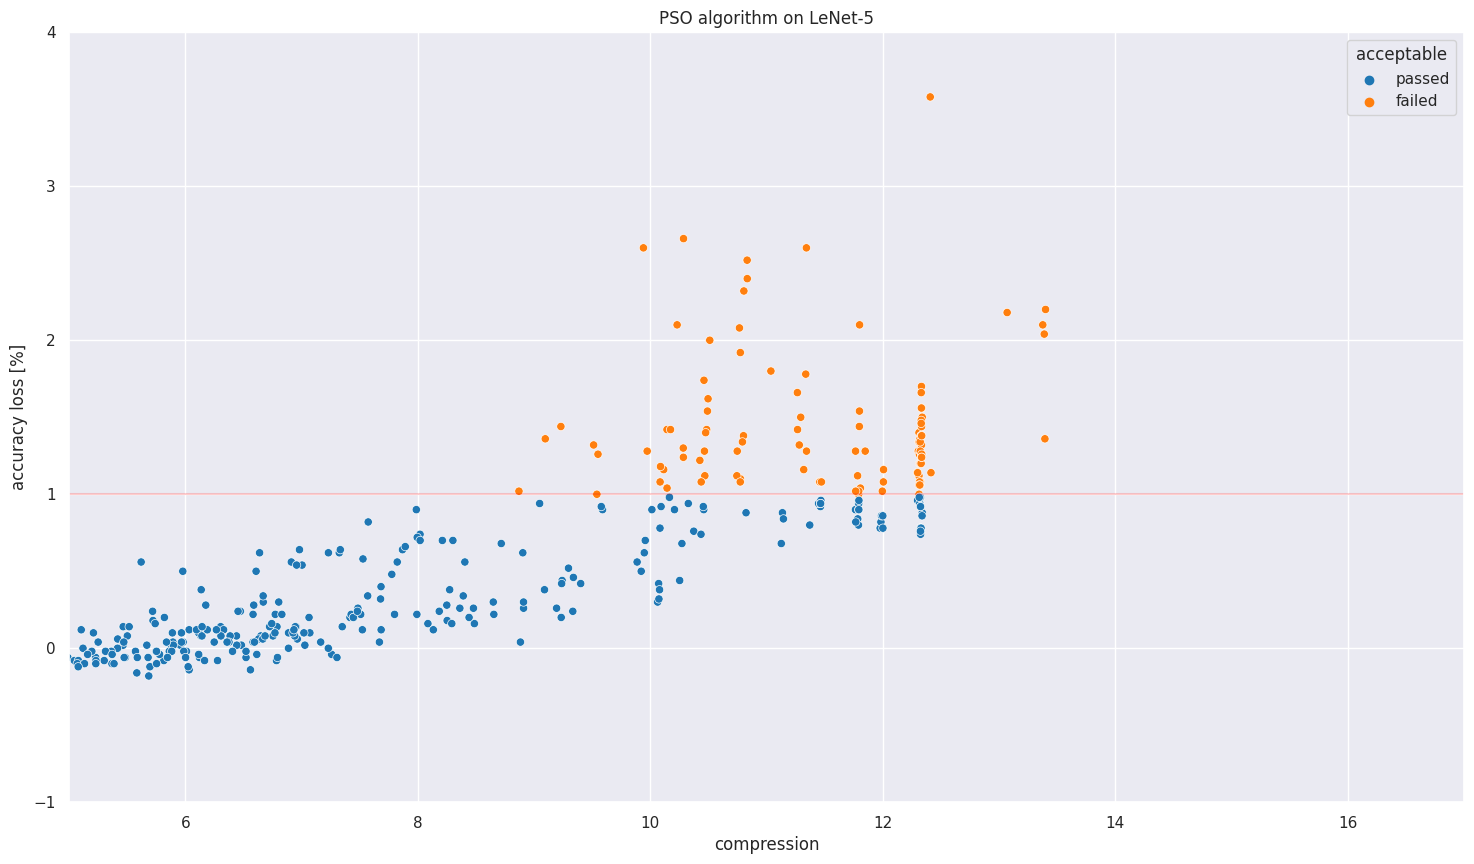

In [10]:
plot_alcr(pso_data)
plt.title('PSO algorithm on LeNet-5')